### Codigo para la propagación de onda elástica 1D en un medio heterogeneo anisotrópico VTI (datos reales de pozo) mediante el esquema velocidad - esfuerzo y rejilla escalonada (usado en tesis)

In [17]:
# Import Libraries 
# ----------------------------------------------
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Input Parameter
# ----------------------------------------------

# Discretization
c2=0.75        # CFL-Number
T=1.25           # Total propagation time

# Source Signal
f0= 50         # Center frequency Ricker-wavelet
q0= 1          # Maximum amplitude Ricker-Wavelet
xscr = 55     # Source position (in grid points)

# Receiver
xrec= 55       # Position Reciever (in grid points)

In [19]:
# Velocity and density

logs = np.loadtxt('ILM13.txt')
x = logs[:,0]         # Space vector
model_vp = logs[:,1]   # P-wave velocity in m/s
rho = logs[:,2]       # Density in Kg/m^3
epsilon = logs[:,6]   # Epsilon parameter

## Preparation 
# ----------------------------------------------

# Calculate Thomsen Parameters
C33 = model_vp**2*rho
C11 = C33*(2*epsilon + 1)

cmin=model_vp.min()    # Lowest P-wave velocity
cmax=model_vp.max()    # Highest P-wave velocity       
dx=x[1]-x[0]          # Spatial discretization (in m)        
dt=0.00004            # Temporal discretization (in s)
CFL=cmax*dt/dx        # CFL-Number
print(dx)
print(dt)

# Create space and time vector
#x=np.arange(0,(dx*nx),dx) # Space vector
t=np.arange(0,T,dt)     # Time vector
nt=len(t)               # Number of time steps
nx=len(x)               # Number of grid points

# Plotting velocity and density model
plt.ion()
fig1 = plt.figure(figsize=(9,10))
plt.subplot(131)
plt.plot(model_vp,x,'r')
plt.title('Velocidad de onda P')
plt.ylabel('m')
plt.xlabel('m/s')
plt.gca().invert_yaxis()
plt.gca().yaxis.grid(True)
plt.subplot(132)
plt.plot(rho,x)
plt.title('Densidad')
plt.xlabel('Kg/m$^3$')
plt.gca().invert_yaxis()
plt.gca().yaxis.grid(True)
plt.subplot(133)
plt.plot(epsilon,x,'k')
plt.title('Epsilon')
plt.xlabel('Adimensional')
plt.gca().invert_yaxis()
plt.gca().yaxis.grid(True)
plt.show()
plt.savefig("vp_rho_well_1D.png", bbox_inches='tight')

0.9997439999999997
4e-05


<IPython.core.display.Javascript object>

In [20]:
# Init wavefields
vx=np.zeros(nx)
sx=np.zeros(nx)

# Attenuation(pml)
pml = 50
R=5e-1;          # theoretical reflection coefficient
ddx=np.zeros(nx)
plx=pml*dx

for i in range(0,nx):
    if i>=0 and i<=pml-1:
        xx=pml-i
        ddx[i]=-np.log(R)*3*cmax*xx**2/(2*plx**2)
    elif i>nx-pml and i<=nx:
        xx=i-(nx-pml-1);
        ddx[i]=-np.log(R)*3*cmax*xx**2/(2*plx**2)

# Source signal - Ricker-wavelet
ond = np.loadtxt('ond_ILM13.txt')
q = ond[:,1]

# Plotting source signal
plt.ion()
fig2 = plt.figure(figsize=(9,4.5))
plt.plot(t,q)
plt.title('Source signal Ricker-Wavelet')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.show()

# Init Seismograms
Seismogram=np.zeros(nt)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


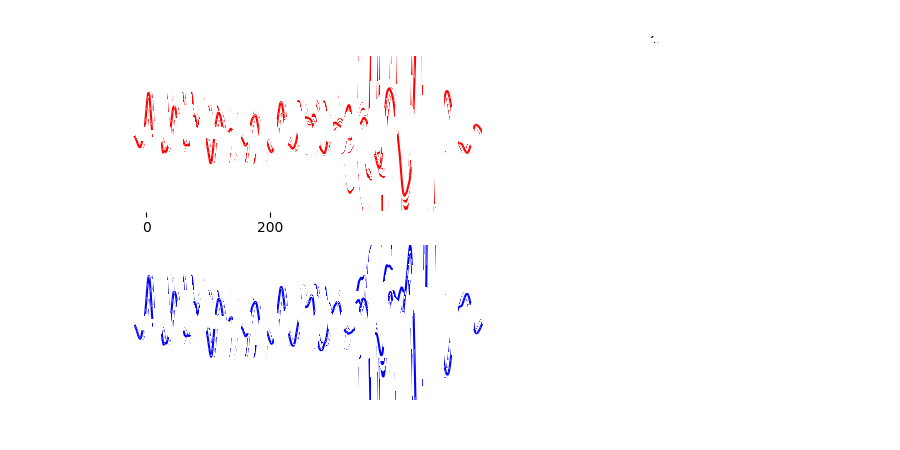

KeyboardInterrupt: 

In [21]:
# First set up the figure, the axis, and the plot element we want to animate
title = "FD Elastic 1D staggered grid"
fig3 = plt.figure(figsize=(9,4.5))
ax1 = fig3.add_subplot(2, 1, 1)
ax2 = fig3.add_subplot(2, 1, 2)
up31, = ax1.plot(x, vx, color = "red", lw = 1.5)  # plot velocity update each time step
up32, = ax2.plot(x, sx, color = "blue", lw = 1.5) # plot pressure update each time step
leg1,= ax1.plot(x[xscr], 0, 'r*', markersize=11) # plot position of the source and receiver in velocity plot
leg2,= ax2.plot(x[xscr], 0, 'r*', markersize=11) # plot position of the source and receiver in pressure plot
ax1.set_ylabel('velocity (m/s)')
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(-5e-7,5e-7)
ax2.set_xlabel('x (m)')
ax2.set_ylabel('Pressure (Pa)')
ax2.set_xlim(x.min(),x.max())
ax2.set_ylim(-1.5,1.5)
plt.show()

# Calculation of some coefficients
c1=9/8
c2=-1/24

# 1D Elastic Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------
## Time extrapolation

for n in range(1,nt-2):
    
    # Inject source wavelet
    sx[xscr]=sx[xscr]+q[n]
    
    # Update velocity
    for kx in range(4,nx-6):
        
            # Calculating spatial derivative
        sx_x=(c1*(sx[kx+1] -  sx[kx]) + c2*(sx[kx+2] -  sx[kx-1]))/dx

            # Update velocity
        vx[kx]=((1-0.5*dt*ddx[kx])*vx[kx]+(dt/rho[kx])*sx_x)/(1+0.5*dt*ddx[kx])    
    
    # Update pressure
    for kx in range(4,nx-6):
        
            # Calculating spatial derivative
        vx_x= (c1*(vx[kx] -  vx[kx-1]) + c2*(vx[kx+1] - vx[kx-2]))/dx
            # Update pressure
        sx[kx]=((1-0.5*dt*ddx[kx])*sx[kx]+C11[kx]*dt*vx_x)/(1+0.5*dt*ddx[kx])    
  
    # Save seismograms
    Seismogram[n]=vx[xrec]
    idisp = 10 # display frequency
    if (n % idisp) == 0:
        up31.set_ydata(vx)
        up32.set_ydata(sx)
        ax1.set_title(title + ", Time Step (nt) = %i" % (n)) 
        plt.gcf().canvas.draw()
plt.close()

In [ ]:
# Plot seismogram 
# ---------------
#plt.ion()
fig4 = plt.figure(figsize=(9,2.50))
plt.plot(t-0.05, Seismogram)
plt.title('Seismogram')
plt.ylabel('Amplitude')
plt.xlabel(' Time (s)')
plt.show()

In [ ]:
traza_iso = np.loadtxt('traza_ILM13.txt')
time=traza_iso[:,0]
amp=traza_iso[:,1]

plt.ion()
fig5 = plt.figure(figsize=(9,4.5))
plt.plot(t[2500:31250]-0.0225, Seismogram[2500:31250]/Seismogram[2500:31250].max())
plt.plot(time, amp/amp.max(),'r-.')
plt
#plt.title('Seismogram')
plt.ylabel('Amplitud')
plt.xlabel(' Tiempo (s)')
plt.show()
#plt.savefig("DFDT_iso_aniso_well_1D.png", bbox_inches='tight')
#np.savetxt('time_ILM13.txt',t)
#np.savetxt('seismoa3_ILM13.txt',Seismogram)